In [ ]:
# PARAMETER
#-------------
# check if IS_MASTER exists, this variable will only exist if it's being called by MASTER notebook.
# if it does not exist, set it to False
try: IS_MASTER
except: IS_MASTER = False
# The code below will only run if it's NOT being called from MASTER notebook
if not IS_MASTER:
    DATA_DIR = './data/temp/'
    EXP_DIR = './exp/temp/'
    PROCESSED_FILE = f'{DATA_DIR}processed.pkl'
    MODEL_FILE = f'{EXP_DIR}model.pkl'
    PREDICTION_FILE = f'{EXP_DIR}pred.pkl'
    OTHER_MODEL_PARAMETERS = ... # like N_ESTIMATOR, GAMMA, etc

In [17]:
blockSize = (2,2)
cellSize = (2,2)
blockStride = (10,10)
winSize = (20,20)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
#compute(img[, winStride[, padding[, locations]]]) -> descriptors
winStride = (10,10)
padding = (10,10)
locations = ((10,20),)


In [52]:
#definition of HOG descriptor

cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# winSize is the size of the image cropped to an multiple of the cell size
hog = cv2.HOGDescriptor(_winSize=(200 // cell_size[1] * cell_size[1],
                                  100 // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

n_cells = (100 // cell_size[0], 200 // cell_size[1])


In [ ]:
hog_feats = hog.compute(img)\
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[0], block_size[1], nbins) \
               .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
# hog_feats now contains the gradient amplitudes for each direction,
# for each cell of its group for each group. Indexing is by rows then columns.

gradients = np.zeros((n_cells[0], n_cells[1], nbins))

# count cells (border cells appear less often across overlapping groups)
cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

for off_y in range(block_size[0]):
    for off_x in range(block_size[1]):
        gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                  off_x:n_cells[1] - block_size[1] + off_x + 1] += \
            hog_feats[:, :, off_y, off_x, :]
        cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                   off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

# Average gradients
gradients /= cell_count

# Preview
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()

bin = 6# angle is 360 / nbins * direction
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [37]:
import glob
import os
import numpy as np
samples = []
labels = []    

positive_path = "data/smalldata/temp/resized/Si/"
negative_path = "data/smalldata/temp/resized/No/"

# Get positive samples
for filename in glob.glob(os.path.join(positive_path, '*.png')):
    img = cv2.imread(filename, 0)
    hist = hog.compute(img)
    samples.append(hist)
    labels.append(1)

# Get negative samples
for filename in glob.glob(os.path.join(negative_path, '*.png')):
    img = cv2.imread(filename, 0)
    hist = hist = hog.compute(img)
    samples.append(hist)
    labels.append(0)

# Convert objects to Numpy Objects
samples = np.float32(samples)
labels = np.array(labels)


# Shuffle Samples
rand = np.random.RandomState(321)
shuffle = rand.permutation(len(samples))
samples = samples[shuffle]
labels = labels[shuffle]    

# Create SVM classifier
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF) # cv2.ml.SVM_LINEAR
# svm.setDegree(0.0)
svm.setGamma(5.383)
# svm.setCoef0(0.0)
svm.setC(2.67)
# svm.setNu(0.0)
# svm.setP(0.0)
# svm.setClassWeights(None)

# Train
svm.train(samples, cv2.ml.ROW_SAMPLE, labels)
svm.save('svm_data.dat')

# Testing:
Now we test the SVM

In [42]:
import cv2

if not os.path.isfile('svm_data.dat'):
    svm = cv2.ml.SVM_create()
    svm.setType(cv2.ml.SVM_C_SVC)
    svm.setKernel(cv2.ml.SVM_RBF) # cv2.ml.SVM_LINEAR
    # svm.setDegree(0.0)
    svm.setGamma(5.383)
    # svm.setCoef0(0.0)
    svm.setC(2.67)
    # svm.setNu(0.0)
    # svm.setP(0.0)
    # svm.setClassWeights(None)

    svm.save('svm_data.dat')
else:
    svm = cv2.ml.SVM_load('svm_data.dat')

#svm.train(samples_train, cv2.ml.ROW_SAMPLE, labels_train)
samples_test=samples
labels_test=labels

resp = svm.predict(samples_test)[1].ravel()
print (resp, labels_test)

err = (labels_test != resp).mean()
print('error: %.2f %%' % (err*100))

from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(labels_test, resp)
print(confusion_mat)

[0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.] [0 0 1 1 0 0 1 1

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

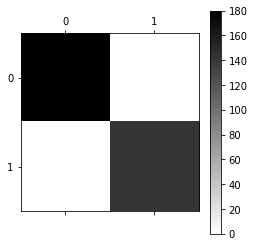

In [43]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(confusion_mat)

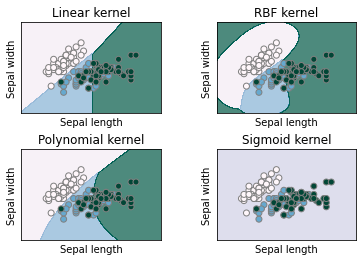

Accuracy Linear Kernel: 0.7333333333333333
Accuracy Polynomial Kernel: 0.7333333333333333
Accuracy Radial Basis Kernel: 0.6666666666666666
Accuracy Sigmoid Kernel: 0.2
[[11  0  0]
 [ 0  8  5]
 [ 0  3  3]]
[[11  0  0]
 [ 0  8  5]
 [ 0  3  3]]
[[11  0  0]
 [ 0  5  8]
 [ 0  2  4]]
[[ 0  0 11]
 [ 0  0 13]
 [ 0  0  6]]


In [49]:
#Importing the necessary packages and libaries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np
iris = datasets.load_iris()
#Store variables as target y and the first two features as X (sepal length and sepal width of the iris flowers)
X = iris.data[:, :2]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 0)

linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)
#stepsize in the mesh, it alters the accuracy of the plotprint
#to better understand it, just play with the value, change it and print it
h = .01
#create the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)
# retrieve the accuracy and print it for all 4 kernel functions
accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
accuracy_rbf = rbf.score(X_test, y_test)
accuracy_sig = sig.score(X_test, y_test)
print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Sigmoid Kernel:", accuracy_sig)
# creating a confusion matrix
cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
cm_sig = confusion_matrix(y_test, sig_pred)
print(cm_lin)
print(cm_poly)
print(cm_rbf)
print(cm_sig)

In [55]:
print(X)

[[5.1 3.5]
 [4.9 3. ]
 [4.7 3.2]
 [4.6 3.1]
 [5.  3.6]
 [5.4 3.9]
 [4.6 3.4]
 [5.  3.4]
 [4.4 2.9]
 [4.9 3.1]
 [5.4 3.7]
 [4.8 3.4]
 [4.8 3. ]
 [4.3 3. ]
 [5.8 4. ]
 [5.7 4.4]
 [5.4 3.9]
 [5.1 3.5]
 [5.7 3.8]
 [5.1 3.8]
 [5.4 3.4]
 [5.1 3.7]
 [4.6 3.6]
 [5.1 3.3]
 [4.8 3.4]
 [5.  3. ]
 [5.  3.4]
 [5.2 3.5]
 [5.2 3.4]
 [4.7 3.2]
 [4.8 3.1]
 [5.4 3.4]
 [5.2 4.1]
 [5.5 4.2]
 [4.9 3.1]
 [5.  3.2]
 [5.5 3.5]
 [4.9 3.6]
 [4.4 3. ]
 [5.1 3.4]
 [5.  3.5]
 [4.5 2.3]
 [4.4 3.2]
 [5.  3.5]
 [5.1 3.8]
 [4.8 3. ]
 [5.1 3.8]
 [4.6 3.2]
 [5.3 3.7]
 [5.  3.3]
 [7.  3.2]
 [6.4 3.2]
 [6.9 3.1]
 [5.5 2.3]
 [6.5 2.8]
 [5.7 2.8]
 [6.3 3.3]
 [4.9 2.4]
 [6.6 2.9]
 [5.2 2.7]
 [5.  2. ]
 [5.9 3. ]
 [6.  2.2]
 [6.1 2.9]
 [5.6 2.9]
 [6.7 3.1]
 [5.6 3. ]
 [5.8 2.7]
 [6.2 2.2]
 [5.6 2.5]
 [5.9 3.2]
 [6.1 2.8]
 [6.3 2.5]
 [6.1 2.8]
 [6.4 2.9]
 [6.6 3. ]
 [6.8 2.8]
 [6.7 3. ]
 [6.  2.9]
 [5.7 2.6]
 [5.5 2.4]
 [5.5 2.4]
 [5.8 2.7]
 [6.  2.7]
 [5.4 3. ]
 [6.  3.4]
 [6.7 3.1]
 [6.3 2.3]
 [5.6 3. ]
 [5.5 2.5]
 [5.5 2.6]

In [ ]:
# create the title that will be shown on the plot
titles = ['Linear kernel','RBF kernel','Polynomial kernel','Sigmoid kernel']
for i, clf in enumerate((linear, rbf, poly, sig)):
    #defines how many plots: 2 rows, 2columns=> leading to 4 plots
    plt.subplot(2, 2, i + 1) #i+1 is the index
    #space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.PuBuGn, alpha=0.7)
# Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.PuBuGn,     edgecolors='grey')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()